In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=4)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [6]:
client

Client Scheduler: tcp://10.148.0.109:35242 Dashboard: http://10.148.0.109:8787/status,Cluster Workers: 28 Cores: 28 Memory: 479.92 GB


### Load data drifters : 

In [7]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'


In [10]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=True)

In [25]:
df = dr.df.loc[225].compute()
#df = df.sort_values('time').set_index('time')

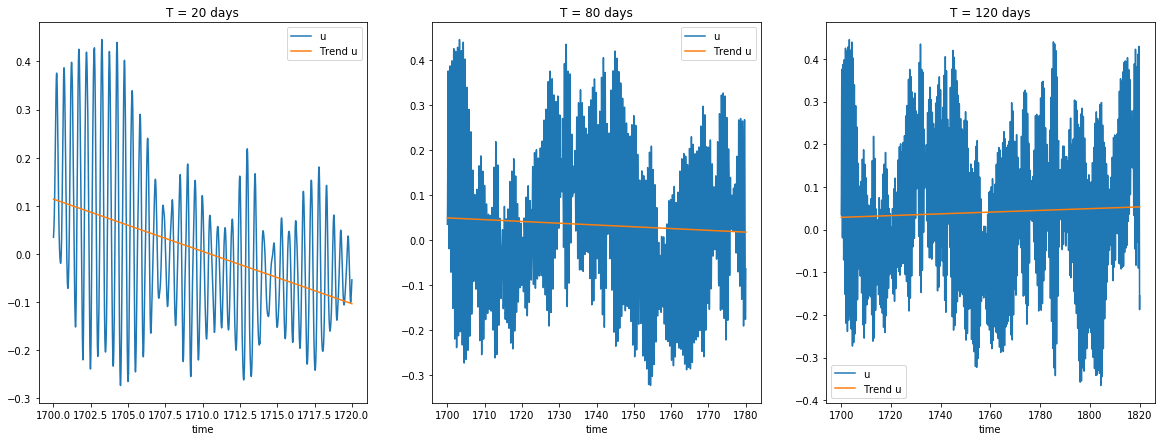

In [12]:
#Example for one drifter : 
from scipy import signal
fig, axs = plt.subplots(1,3,figsize=(20,7))
for T,ax in zip([20,80,120],axs):
    df.u.loc[1700:1700+T].plot(ax=ax, label='u')
    (df.u.loc[1700:1700+T]-signal.detrend(df.u.loc[1700:1700+T])).plot(ax=ax,label='Trend u')
    ax.legend();ax.set_title( 'T = %s days' % T)

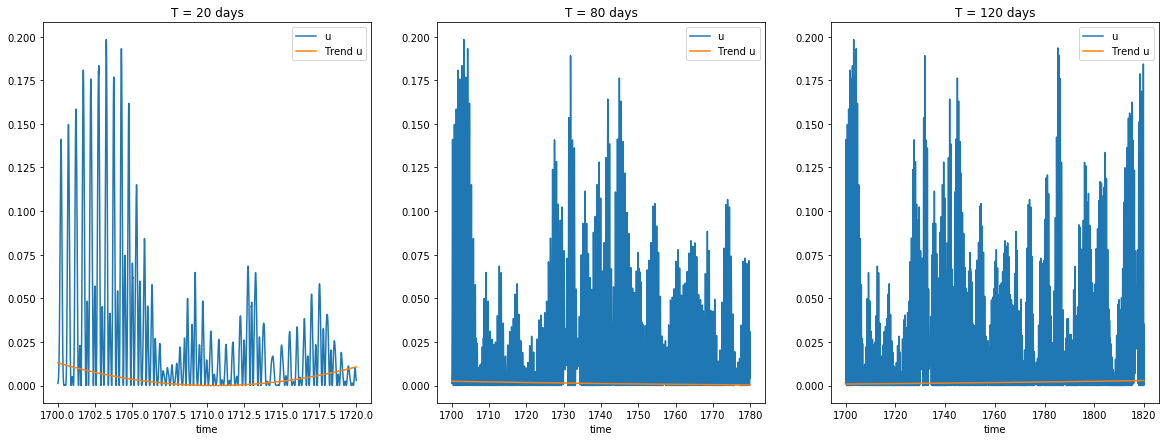

In [20]:
fig, axs = plt.subplots(1,3,figsize=(20,7))
for T,ax in zip([20,80,120],axs):
    ((df.u.loc[1700:1700+T])**2).plot(ax=ax, label='u')
    ((df.u.loc[1700:1700+T]-signal.detrend(df.u.loc[1700:1700+T]))**2).plot(ax=ax,label='Trend u')
    ax.legend();ax.set_title( 'T = %s days' % T)

In [8]:
def trend_mean(v1,v2,N):
#    fltI = flt.sel(time=slice(Ti,Tf))
    if v1 is None and v2 is None:
        return pd.Series(np.random.randn(N),index=['trend_var_0','trend_var_1','mean_var_0','mean_var_1'])
    else : 
        _v1 = v1
        _v2 = v2
        _v1 = signal.detrend(v1)
        _v2 = signal.detrend(v2)
        trend_var_1 = np.mean((v1-_v1)**2)
        trend_var_2 = np.mean((v2-_v2)**2)
        mean_var_1 = np.mean(v1)
        mean_var_2 = np.mean(v2)
        return pd.Series([trend_var_1,trend_var_2,mean_var_1,mean_var_2],
                         index=['trend_var_0','trend_var_1','mean_var_0','mean_var_1'])#,fltI.v

In [33]:
L = 1026
out = cdr.time_window_processing(df, trend_mean,['u','v'],80,4,L)

In [34]:
out

,x,y,id,trend_var_0,trend_var_1,mean_var_0,mean_var_1
1540.0069,53.630371,1961.574268,225.0,0.004272,0.001051,0.031941,-0.011375
1580.0069,253.474002,1837.899409,225.0,0.008135,0.002412,0.070578,-0.033073
1620.0069,483.312260,1768.171541,225.0,0.002551,0.003777,0.049105,-0.044933
1660.0069,621.419837,1796.222157,225.0,0.007851,0.000462,0.070520,0.013105
1700.0069,910.870958,1853.506590,225.0,0.005412,0.008209,0.073567,0.053153
1740.0069,92.032447,1935.470426,225.0,0.001206,0.000899,0.033501,0.002850
1780.0069,213.370499,1916.234366,225.0,0.001715,0.000085,0.035270,0.009074
1820.0069,317.458897,1934.643145,225.0,0.001308,0.000891,0.035923,0.023864
1860.0069,491.028623,1947.617370,225.0,0.008612,0.001191,0.081411,0.017128
1900.0069,787.014718,2023.331620,225.0,0.014748,0.002928,0.031063,0.021455


In [9]:
L = 1026
def apply_window(myfun,columns,T,N,L,binsize):
    """Compute diags_dist and returns xarray"""
    df_chunked = dr.df.groupby(dr.df.index).apply(cdr.time_window_processing, myfun, 
                                                  columns,T,N,L
                                                 )#.persist()
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
    df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
    DF = df_chunked.compute()
    return DF.set_index(DF.y_cut.map(lambda v: v.mid)).drop(columns=['time','x','y']).rename(columns={'y_cut':'y_bins'}).to_xarray()

In [ ]:
out = apply_window(trend_mean,['u','v'],80,4,L,50)

In [ ]:
cluster.close()